In [1]:
# Functions

In [2]:
def get_words(line):
    r'''
    This function takes a text and returns
    a list of lowercase words. It removes all digits
    and strips punctuation characters from the words.
    
    >>> get_words('Here are severall1000 words!\n Blub')
    ['here', 'are', 'severall', 'words', 'blub']
    
    >>> get_words('"Where are they? 10 \t 1000!?"')
    ['where', 'are', 'they']
    
    >>> get_words('\t\t\t\r\r\r\n<ada> hallo12 \r\t\t\t\t')
    ['ada', 'hallo']
    
    '''
    import re
    line = re.sub('\s*[\r\t]+','',line)
    line = line.lower()
    line = re.sub('[^+#a-z\s\'-]+','',line)

    
    words = line.split()
    return words

if __name__ == '__main__':
    import doctest
    doctest.testmod()

# Data Import

In [3]:
import pandas as pd
import json
from collections import Counter

# Columns which shall be kept from the downloaded data
columns = ['job_title', 'employer', 'origin', 'location',
           'salary', 'job_type', 'job_description',]

# Keywords to check for in the job description. Each keyword 
# gets its own column with True and False values.
languages = ['python', 'java', 'perl', 'r', 'sql', 'ruby', 
             'c++', 'c', 'c#', 'html', 'css', 'javascript', 
             'fortran', 'git', 'github']

informatician = ['bioinformatician', 'bioinformatics']

#keywords for later duplicate deleting
duplicate_pattern = ['researcher', 'details', 'skills', 'successful',
                     'program', 'expected', 'strong']

#List of programming related words, later used to check if job offer
#is programming related / involves programming
prog_related = ['programming', 'programing', 'code', 'coding', 
                'computational', 'programming-language', 'script',
                'scripting', 'script-language', 'informatics'
               ]

# load nature jobs
with open('ls_jobs/nature_jobs.json', 'r') as myfile:
    nature_jobs = json.load(myfile)

# load science jobs
with open('ls_jobs/science_jobs.json', 'r') as myfile:
    science_jobs = json.load(myfile)

# Count words and add an orign entry to the science data
for entry in science_jobs:
    entry['job_description_words'] = Counter(get_words(entry['job_description']))
    entry['origin'] = 'science'

# Count words and add an orign entry to the nature data
for entry in nature_jobs:
    entry['job_description_words'] = Counter(get_words(entry['job_description']))
    entry['origin'] = 'nature'

# Combine the job data from science and nature
job_data = science_jobs+nature_jobs

# Add the entries for the keywords
for entry in job_data:
    for keyword in (languages + informatician + duplicate_pattern):
        if keyword in entry['job_description_words'].keys():
            entry[keyword] = entry['job_description_words'][keyword]
        else:
            entry[keyword] = 0
    #check if job offer is programming related, if so set to True
    for prog_word in (prog_related + languages + informatician):
        if prog_word in entry['job_description_words'] or 'Bioinformatic' in entry['job_type']:
            entry['programming_related'] = True
            break
        else:
            entry['programming_related'] = False

# Read the data into a dataframe and select the specified columns
df = pd.DataFrame(job_data)
#only keep specific columns (entries of the added lists)
df = df[(columns + ['programming_related'] + languages +
        duplicate_pattern + informatician)]

#df['successful'][:10]
#df[df['job_type'].str.contains('Bioinformatic')]
#df['job_type'][df['origin']=='science']

# Inspect data

In [4]:
#get and print number of entries in dataset pre duplicate deletion
print('Dataset before duplicate reduction')
print('Total Number of job offers/entries:')
entries_pre_del = len(df)
print(entries_pre_del)
print('Number of job offers/entries from Science:')
sci_entries_pre_del = len(df[df['origin']=='science'])
print(sci_entries_pre_del)
print('Number of job offers/entries from Nature:')
nat_entries_pre_del = len(df[df['origin']=='nature'])
print(nat_entries_pre_del)

Dataset before duplicate reduction
Total Number of job offers/entries:
3032
Number of job offers/entries from Science:
1041
Number of job offers/entries from Nature:
1991


## Remove duplicates

Here we remove duplicates by two different approaches. First we remove all rows from our pandas DataFrame which are not unique. A row is unique if there is no other row which has the same values in every column. 

In [5]:
#remove completly identical entries
df[df.duplicated()==True]
df = df[df.duplicated()==False]

In [6]:
#delete entries which seem to be duplicates 
#according to the word occurences
df = df[df.duplicated(subset=['job_title', 'employer',
                           'researcher', 'details',
                           'skills', 'successful',
                           'program', 'expected',
                           'strong'])==False]

In [7]:
#get and print number of entries in dataset post duplicate deletion
print('Dataset after duplicate reduction')
print('Total Number of job offers/entries:')
print(len(df))
print('Number of job offers/entries from Science:')
print(len(df[df['origin']=='science']))
print('Number of job offers/entries from Nature:')
print(len(df[df['origin']=='nature']))

Dataset after duplicate reduction
Total Number of job offers/entries:
2956
Number of job offers/entries from Science:
1022
Number of job offers/entries from Nature:
1934


In [8]:

jtype_binf = len(df[(df['job_type'].str.contains('Bioinformatic')) |
                (df['job_type'].str.contains('bioinformatic'))])

print('Number of jobs associated with bioinformatics:')
print(jtype_binf)

print(len(df[(df['bioinformatics']>0) |
             (df['bioinformatician']>0) |
             (df['job_type'].str.contains('Bioinformatic'))]))

Number of jobs associated with bioinformatics:
133
421


In [9]:
x = df[(df['bioinformatics']>0) |
       (df['bioinformatician']>0)]

print(len(x[(x['job_type'].str.contains('Bioinformatic'))]))

90


# Question 1: Which programming languages are mentioned most often in job ads for bioinformaticians?

In [10]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

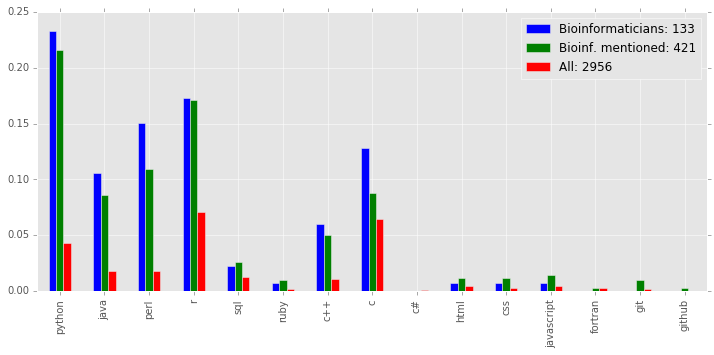

In [11]:
plot_data = df[languages]

bioinf = plot_data.loc[(df['job_type'].str.contains('Bioinformatic')) |
                                 (df['job_type'].str.contains('Chemoinformatic'))]


mentioned_bioinf = plot_data[(df['bioinformatics']>0) |
                             (df['bioinformatician']>0) |
                             (df['job_type'].str.contains('Bioinformatic')) |
                             (df['job_type'].str.contains('Chemoinformatic'))]

all_jobs = plot_data

plotframe = pd.concat([bioinf.sum()/len(bioinf),
                       mentioned_bioinf.sum()/len(mentioned_bioinf),
                       all_jobs.sum()/len(all_jobs)], axis=1)

plotframe.set_index(plot_data.sum().index)
plotframe = plotframe.rename(index = str, columns={0:'Bioinformaticians: '+str(len(bioinf)),
                                                   1:'Bioinf. mentioned: '+str(len(mentioned_bioinf)),
                                                   2:'All: '+str(len(all_jobs))})
ax = plotframe.plot(kind='bar', figsize=(12, 5))

# Programming in Biology

## How many job offers are programming related?

In [12]:
#subsample programming related column
data_prj = df['programming_related']

#get programming related jobs and not programming related jobs
prog_rel_jobs = sum(data_prj)/len(data_prj)
no_prog_rel_jobs = 1 - prog_rel_jobs

"""
#code for plotting
#plotting doesn't really make sense. no information gain and not 
#easier to explain stuff with plot. hard numbers say enough
ax = plt.subplot()
ax.set_xticks = [0, 0.5, 1, 1.5]
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_ylim([0,1])
ax.set_xticklabels(['', 'programming_related', '' ,'not_related'])
ax.bar(0.5, prog_rel_jobs, width = 0.5)
ax.bar(1, no_prog_rel_jobs, width = 0.5)

plt.show()
"""
print(prog_rel_jobs)
print(no_prog_rel_jobs)

0.332882273342
0.667117726658


# Which languages are mentioned together

CHECK FOR CORRELATION BETWEN LANGUAGE OCCURANCES

In [13]:
from scipy.stats.stats import pearsonr
#man muss sich nochmal angucken,
#was genau die pearson cor macht
#population eingrenzen

pearsonr(mentioned_bioinf['r'], mentioned_bioinf['python'])

(0.5890735957911547, 1.1008362062599692e-40)

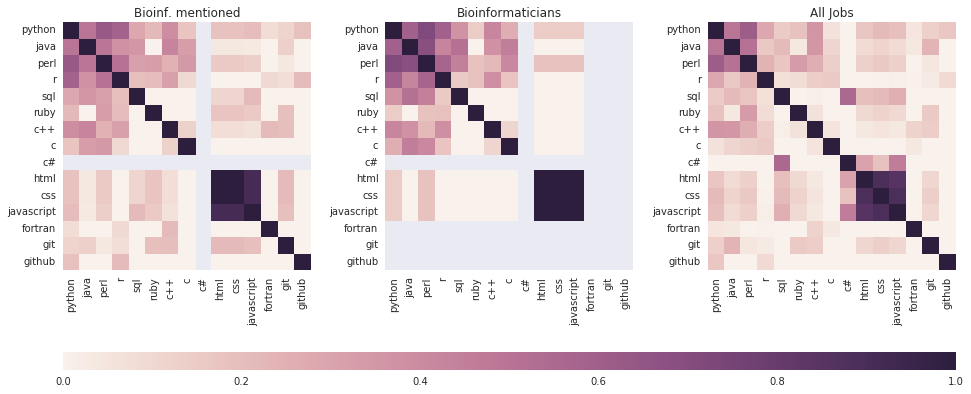

In [14]:
import seaborn as sns
import matplotlib.gridspec as gridspec

# Compute the correlation between all languages
lang_corr_m = mentioned_bioinf.corr(method='pearson')
lang_corr_b = bioinf.corr(method='pearson')
lang_corr_a = all_jobs.corr(method='pearson')

# Set up the matplotlib figure
gs = gridspec.GridSpec(2, 3, height_ratios=[0.95,0.03])
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[1, :])

plt.subplots_adjust(wspace=0.3, hspace=-0.25)
f = plt.gcf()
f.set_size_inches(16, 9)

# Draw the heatmap using seaborn
ax1.set_title('Bioinf. mentioned')
sns.heatmap(lang_corr_m, ax = ax1, vmin = 0, cbar = False, square=True)

ax2.set_title('Bioinformaticians')
sns.heatmap(lang_corr_b, ax = ax2, vmin = 0, cbar = False, square=True)

ax3.set_title('All Jobs')
sns.heatmap(lang_corr_a, ax = ax3, vmin = 0, square=True,
            cbar_ax=ax4, cbar_kws={"orientation": "horizontal"})